<a href="https://colab.research.google.com/github/chandrusuresh/ReinforcementLearning/blob/master/Ch5-MonteCarloMethods/RaceTrack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
from tqdm import tqdm
from enum import Enum
# np.random.seed(0)

# Race Track

This is the solution to Exercise-5.12 in Page-111 of the book ["Reinforcement Learning" by Barto, Sutton](http://incompleteideas.net/sutton/book/the-book.html).

The summary of the problem is as follows:
1. We have a map of a race track that is discretized by a grid of cells. Each cell corresponds to a position on the race track.
2. The goal is to find the optimal path from a set of cells marked start line to another set of cells marked the finish line. For simplicity, the start line is assumed to be in the last row of the grid (bottom) and finish line is assumed to be in the last column of the grid (right).
3. The track also has a set of valid & invalid cells. The invalid cells represent obstacles or out-of-bounds. No path is allowed to pass through an obstacle.
4. Each time a path gets on a cell labelled obstacle, the position resets to a random start cell and the episode continues. The episode ends with the final state vector passes through or gets to any cell labeled finish line.
5. The state vector is given by the position and velocity in the x & y directions. i.e. $\text{state} = [p_x,p_y,v_x,v_y]$ where $p,v$ represent the position and velocity.
5. The input vector is the acceleration at each time step given by: $\text{input} = [a_x,a_y]$ where $a_x,a_y \in \{-1,0,1\}$. The maximum number of possible actions is therefore (=3 $\times$ 3) 9.
6. In the simplest case, the state transition is a deterministic function of the current state and action. The state transition is computed as follows:
$$ \begin{align*} \left[\begin{matrix} p_x \\p_y \\ v_x \\ v_y\end{matrix} \right]_{k+1} &= \left[ \begin{matrix} 1 & 0 & 1 & 0 \\ 0 & 1 & 0 & 1 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{matrix}\right] \left[\begin{matrix} p_x \\p_y \\ v_x \\ v_y\end{matrix} \right]_{k}+ \left[ \begin{matrix} 1 & 0 \\ 0 & 1 \\ 1 & 0 \\ 0 & 1 \end{matrix}\right] \left[ \begin{matrix} a_x \\ a_y \end{matrix}\right]_k \\ \\
\Rightarrow s_{k+1} &= A s_k + B a_k \end{align*}$$

##### **Bonus Challenge**
8. The above deterministic transition condition is relaxed as follows where the velocity increments (accleration input) are 0 with probability 0.1
$$ \Rightarrow s_{k+1} = \Bigg\{ \begin{matrix} A s_k + B a_k & \text{with probabilty=0.9} \\ A s_k & \text{with probabilty=0.1} \end{matrix}$$ 


### Initialize Tracks

In [2]:
VALID = 0
START = 1
PATH = 2
FINISH = 3
OBSTACLE = 4

def get_circuits():
  nRows_1 = 32
  nCols_1 = 17
  map_1 = np.zeros((nRows_1,nCols_1),dtype=np.int8)
  map_1[-1,3:9] = START
  map_1[0:6,-1] = FINISH
  map_1[-3:,:3] = OBSTACLE
  map_1[-10:-3:,:2] = OBSTACLE
  map_1[-18:-10:,:1] = OBSTACLE
  map_1[0,:3] = OBSTACLE
  map_1[1:3,:2] = OBSTACLE
  map_1[3,:1] = OBSTACLE
  map_1[7:,9:] = OBSTACLE
  map_1[6,10:] = OBSTACLE

  nRows_2 = 30
  nCols_2 = 32
  map_2 = np.zeros((nRows_2,nCols_2),dtype=np.int8)
  map_2[-1,:23] = START
  map_2[0:9,-1] = FINISH
  map_2[-17:,23:] = OBSTACLE
  map_2[-18:,24:] = OBSTACLE
  map_2[-19:,26:] = OBSTACLE
  map_2[-20:,27:] = OBSTACLE
  map_2[-21:,30:] = OBSTACLE
  map_2[0,:16] = OBSTACLE
  map_2[[1,8],:13] = OBSTACLE
  map_2[[2,7],:12] = OBSTACLE
  map_2[3:7,:11] = OBSTACLE
  map_2[9:14,:14] = OBSTACLE
  c = 1
  for i in range(14,nRows_2-2):
    map_2[i,:14-c] = OBSTACLE
    c += 1
  return map_1,map_2

def plot_circuit(fig,map,num):
  nRows,nCols = map.shape
  # create discrete colormap
  #cmap = colors.ListedColormap(['red', 'blue'])
  cmap = colors.ListedColormap(['white','red','blue','green','black'])
  bounds = [0,0.1,3]
  norm = colors.BoundaryNorm(bounds, cmap.N)
  ax = fig.add_subplot(1,2,num)
  ax.imshow(map, cmap=cmap)#, norm=norm)

  ### draw gridlines
  # ax = plt.gca();
  ax.set_xticks(np.arange(-0.5, nCols+0.5, 1));
  ax.set_yticks(np.arange(-0.5, nRows+0.5, 1));
  ax.set_xticklabels(np.arange(-0.5, nCols+0.5, 1));
  ax.set_yticklabels(np.arange(-0.5, nRows+0.5, 1));
  ax.grid(color='k', linestyle='-', linewidth=1)

  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.xaxis.set_ticks_position('none')
  ax.yaxis.set_ticks_position('none')

### Visualize Race Tracks

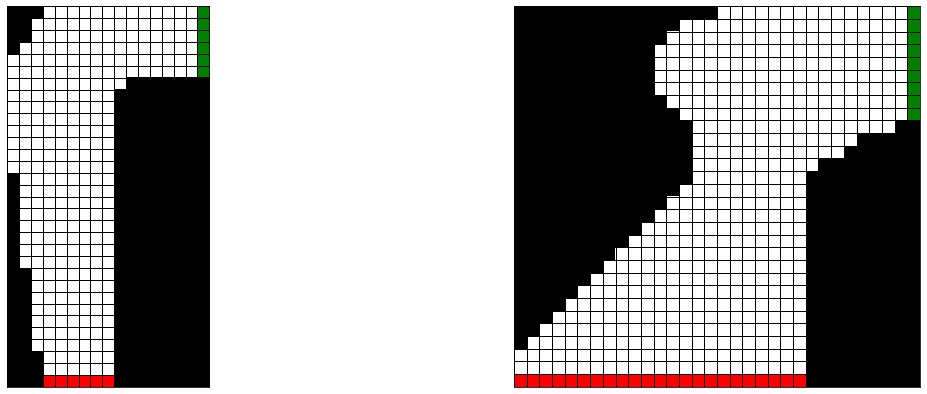

In [3]:
map_1,map_2 = get_circuits()
fig = plt.figure(figsize=(20,7))#20,7)
plot_circuit(fig,map_1,1)
plot_circuit(fig,map_2,2)

### Constants

In [4]:
max_velocity = 5
actions = np.array([[-1,-1],[-1,0],[-1,1],[0,-1],[0,0],[0,1],[1,-1],[1,0],[1,1]])
gamma = 1.0
A_mat = np.matrix([[1,0,1,0],[0,1,0,1],[0,0,1,0],[0,0,0,1]])
B_mat = np.matrix([[1,0],[0,1],[1,0],[0,1]])

## Path Finding

First, we try to solve the relax the optimal requirement in the problem statement and focus just on being able to find a feasible trajectory from the start to finish line. For this, the Monte-Carlo Off-policy control algorithm in Page-111 of the book is used.
1. Behavior policy. The behavior policy is set up to allow exploration of all states and satisfy the problem constraints simultaneously.
2. The behavior policy is made restrictive to satisfy the problem constraints to allow more valid control inputs through the MC simulation. This allows a greater fraction of the episodes to terminate and leads to more coverage. In addition, encoding the known constraints in the behavior policy does not hurt exploration in any way. Some of these constraints are encoded in the behavior policy are as follows: 

*   The path is forbidden to leave the grid from the initial state. This is redundant since the condition for out-of-bounds is checked every step, but is included to speed up convergence
*   The velocity components cannot both be zero at any cell other than the start line. This means that any action that makes the speed zero in any valid cell is forbidden by the behavior policy
*   The speeds in both directions cannot exceed the max speed limit of 5 units. So the acceleration inputs that increase/decrease the velocith below this threshold are forbidden.

>   The behavior policy chooses the actions that satisfy the above constraints with equal probability.

3. This part of the problem focusses only on path-finding, therefore the reward is therefore modified to be terminal and all states in the trajectory are given a reward of +1 on reaching the finish line and -1 for going out-of-bounds.









In [5]:
def init_state(map):
  find_start_line = np.where(map == START)
  choice = np.random.choice(range(len(find_start_line[0])))
  init = [find_start_line[0][choice],find_start_line[1][choice],0,0]
  return init

def check_termination(map,curr_state):
  finish_line = np.where(map == FINISH)
  return curr_state[1] >= finish_line[1][0] and curr_state[0] >= np.min(finish_line[0]) and curr_state[0] <= np.max(finish_line[0])

def check_OutOfBounds(map,curr_state):
  if min(curr_state[0],curr_state[1]) < 0:
    return True
  elif check_termination(map,curr_state):
    return False
  elif curr_state[1] >= map.shape[1] or curr_state[0] >= map.shape[0]:
    return True
  return map[curr_state[0],curr_state[1]] == OBSTACLE

def is_init(map,state):
  return map[state[0],state[1]] == START

def move(state,input):
  new_vel = [state[2]+input[0],state[3]+input[1]]
  new_state = [state[0]+new_vel[0],state[1]+new_vel[1]] + new_vel
  return new_state,new_vel

def behavior_policy(map,state):
  act_idx = np.arange(actions.shape[0])
  prob = 1
  if is_init(map,state):
    idx = np.where(actions[:,0] < 0)[0]
    prob = 1/float(len(idx))
    act_idx = idx
  # elif state[2]==0 and state[3] == 0:
  #   idx = np.arange(actions.shape[0])
  #   act_idx = np.delete(idx,[4])
  #   prob = 1/float(len(act_idx))
  else:
    idx = [i for i in range(actions.shape[0]) if state[2]+actions[i,0] == 0 and state[3]+actions[i,1] == 0]
    act_idx = np.delete(act_idx,idx)
    prob = 1/float(len(act_idx))
  if state[2] == max_velocity:
    idx = np.where(actions[:,0] < 1)[0]
    prob = 1/float(len(idx))
    act_idx = idx
  elif state[2] == -max_velocity:
    idx = np.where(actions[:,0] > -1)[0]
    prob = 1/float(len(idx))
    act_idx = idx
  if state[3] == max_velocity:
    idx = np.where(actions[act_idx,1] < 1)[0]
    prob = 1/float(len(idx))
    act_idx = act_idx[idx]
  elif state[3] == -max_velocity:
    idx = np.where(actions[act_idx,1] > -1)[0]
    prob = 1/float(len(idx))
    act_idx = act_idx[idx]
  if len(act_idx) == actions.shape[0]:
    prob = 1/float(actions.shape[0])
    act_idx = [np.random.choice(range(actions.shape[0]))]
  return actions[np.random.choice(act_idx),:],np.round(prob,3)

def get_action_idx(action):
  return np.where(np.sum(np.abs(actions-action),1) == 0)[0][0]

def play(map,init):
  curr_state = np.copy(init)
  reward = 0
  traj = [curr_state]
  action_prob = []
  while not check_termination(map,curr_state):
    reward -= 1
    act,prob = behavior_policy(map,curr_state)
    next_state,new_vel = move(curr_state,act)
    # print("################")
    # print(curr_state)
    # print(new_vel)
    # print(next_state)
    if check_OutOfBounds(map,next_state):
      return -1,traj,action_prob
      # curr_state = init_state(map)
      # traj = [curr_state]
      # action_prob = []
      # continue
    else:
      curr_state = next_state
    action_prob += [list(act) + [prob]]
    traj += [curr_state]
  return 1,traj,action_prob

def target_policy(Q,state):
  best_action = [np.argmax(Q[state[0],state[1],max_velocity+state[2],max_velocity+state[3],:])]
  if len(best_action) < 1:
    print('No Best Action')
    print('State:',state)
    print('Action:',Q[state[0],state[1],:])
  return np.random.choice(best_action),np.round(1/float(len(best_action)),3)

def play_target(map,Q,init):
  curr_state = np.copy(init)
  reward = 0
  traj = [curr_state]
  action_prob = []
  while not check_termination(map,curr_state):
    reward -= 1
    a,prob = target_policy(Q,curr_state)
    act = actions[a]
    new_vel = [curr_state[2]+act[0],curr_state[3]+act[1]]
    next_state = [curr_state[0]+new_vel[0],curr_state[1]+new_vel[1],new_vel[0],new_vel[1]] 
    if check_OutOfBounds(map,next_state):
      # curr_state = init_state(map)
      break
    else:
      curr_state = next_state
    action_prob += [list(act) + [prob]]
    traj += [curr_state]
  return reward,traj,action_prob

def MonteCarlo_OffPolicyControl(map,num_episodes):
  nRows,nCols = map.shape
  action_values  = np.zeros((nRows,nCols,2*max_velocity+1,2*max_velocity+1,len(actions)))
  action_weights = np.zeros((nRows,nCols,2*max_velocity+1,2*max_velocity+1,len(actions)))

  for episode in tqdm(range(num_episodes)):
    init = init_state(map)
    reward,traj,action_prob = play(map,init)
    G = 0
    W = 1
    for i in range(len(traj)-2,-1,-1):
      t = traj[i]
      act_prob = action_prob[i]
      G = reward#gamma*G + reward
      act_idx = get_action_idx(np.array(act_prob[:2]))
      action_weights[t[0],t[1],max_velocity+t[2],max_velocity+t[3],act_idx] += W
      action_values[t[0],t[1],max_velocity+t[2],max_velocity+t[3],act_idx] += W/action_weights[t[0],t[1],max_velocity+t[2],max_velocity+t[3],act_idx]*(G-action_values[t[0],t[1],max_velocity+t[2],max_velocity+t[3],act_idx])
      pi_t,_ = target_policy(action_values,t)
      if pi_t != act_idx:
        break
      W = W/act_prob[-1]
  return action_values

def generate_path(map,Q):
  final_map = []
  for k in range(2):
    init = init_state(map)
    reward,traj,action_prob = play_target(map,Q,init)
    print('Reward = :',reward)
    final_map.append(np.copy(map))
    for i,t in enumerate(traj):
      final_map[-1][min(t[0],map.shape[0]-1),min(t[1],map.shape[1]-1)] = PATH
  fig = plt.figure(figsize=(20,7))
  plot_circuit(fig,final_map[0],1)
  plot_circuit(fig,final_map[1],2)

## Monte-Carlo Off-Policy Control

In [6]:
num_episodes = 100000

Q1 = MonteCarlo_OffPolicyControl(map_1,num_episodes)

Q2 = MonteCarlo_OffPolicyControl(map_2,num_episodes)

100%|██████████| 100000/100000 [01:28<00:00, 1130.54it/s]


Reward = : -12
Reward = : -18


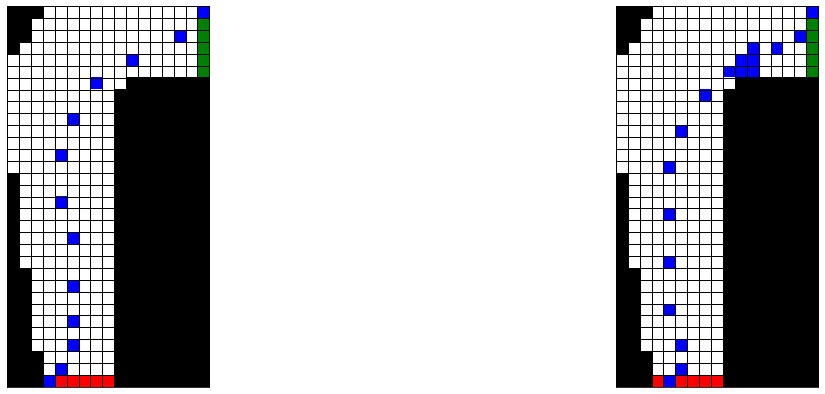

In [7]:
generate_path(map_1,Q1)

Reward = : -12
Reward = : -11


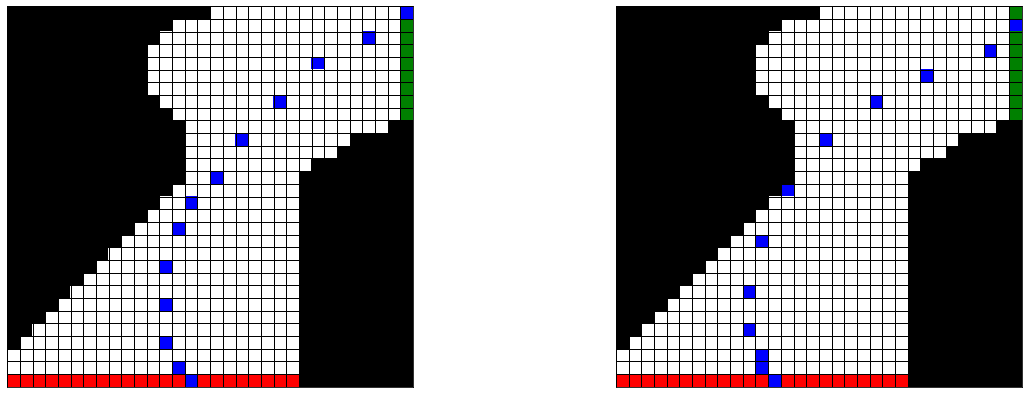

In [8]:
generate_path(map_2,Q2)

In [29]:
def play_opt(map,init):
  curr_state = np.copy(init)
  reward = 0
  traj = [curr_state]
  action_prob = []
  while not check_termination(map,curr_state):
    reward -= 1
    act,prob = behavior_policy(map,curr_state)
    next_state,new_vel = move(curr_state,act)
    if check_OutOfBounds(map,next_state):
      return -100,traj,action_prob
    else:
      curr_state = next_state
    action_prob += [list(act) + [prob]]
    traj += [curr_state]
  return reward,traj,action_prob

def generate_opt_path(map,Q):
  final_map = []
  for k in range(2):
    init = init_state(map)
    # reward,traj,action_prob = play_target(map,Q,init)
    reward,traj,action_prob = play_opt(map,init)
    print('Reward = :',reward)
    final_map.append(np.copy(map))
    for i,t in enumerate(traj):
      final_map[-1][min(t[0],map.shape[0]-1),min(t[1],map.shape[1]-1)] = PATH
  fig = plt.figure(figsize=(20,7))
  plot_circuit(fig,final_map[0],1)
  plot_circuit(fig,final_map[1],2)

def MonteCarlo_OffPolicyOptimalControl(map,num_episodes):
  nRows,nCols = map.shape
  action_values  = np.zeros((nRows,nCols,2*max_velocity+1,2*max_velocity+1,len(actions)))
  action_weights = np.zeros((nRows,nCols,2*max_velocity+1,2*max_velocity+1,len(actions)))

  for episode in tqdm(range(num_episodes)):
    init = init_state(map)
    reward,traj,action_prob = play_opt(map,init)
    G = 0
    W = 1
    for i in range(len(traj)-2,-1,-1):
      t = traj[i]
      act_prob = action_prob[i]
      G = reward#gamma*G + reward
      act_idx = get_action_idx(np.array(act_prob[:2]))
      action_weights[t[0],t[1],max_velocity+t[2],max_velocity+t[3],act_idx] += W
      action_values[t[0],t[1],max_velocity+t[2],max_velocity+t[3],act_idx] += W/action_weights[t[0],t[1],max_velocity+t[2],max_velocity+t[3],act_idx]*(G-action_values[t[0],t[1],max_velocity+t[2],max_velocity+t[3],act_idx])
      pi_t,prob_t = target_policy(action_values,t)
      # if pi_t != act_idx:
      #   break
      # print("out of break")
      W = W*prob_t/act_prob[-1]
  return action_values

def opt_target_policy(Q,state):
  Q_val = Q[state[0],state[1],max_velocity+state[2],max_velocity+state[3],:]
  idx = np.where(Q_val != 0)[0]
  best_action = [idx[np.argmax(Q_val[idx])]]
  return np.random.choice(best_action),np.round(1/float(len(best_action)),3)

def play_opt_target(map,Q,init):
  curr_state = np.copy(init)
  reward = 0
  traj = [curr_state]
  action_prob = []
  while not check_termination(map,curr_state):
    reward -= 1
    a,prob = opt_target_policy(Q,curr_state)
    act = actions[a]
    new_vel = [curr_state[2]+act[0],curr_state[3]+act[1]]
    next_state = [curr_state[0]+new_vel[0],curr_state[1]+new_vel[1],new_vel[0],new_vel[1]] 
    if check_OutOfBounds(map,next_state):
      # curr_state = init_state(map)
      break
    else:
      curr_state = next_state
    action_prob += [list(act) + [prob]]
    traj += [curr_state]
  return reward,traj,action_prob

def generate_opt_path(map,Q):
  final_map = []
  for k in range(2):
    init = init_state(map)
    reward,traj,action_prob = play_opt_target(map,Q,init)
    print('Reward = :',reward)
    final_map.append(np.copy(map))
    for i,t in enumerate(traj):
      final_map[-1][min(t[0],map.shape[0]-1),min(t[1],map.shape[1]-1)] = PATH
  fig = plt.figure(figsize=(20,7))
  plot_circuit(fig,final_map[0],1)
  plot_circuit(fig,final_map[1],2)

In [30]:
num_episodes = 100000

Q1_opt = MonteCarlo_OffPolicyOptimalControl(map_1,num_episodes)

# Q2_opt = MonteCarlo_OffPolicyOptimalControl(map_2,num_episodes)

100%|██████████| 100000/100000 [01:14<00:00, 1347.45it/s]


Reward = : -20
Reward = : -17


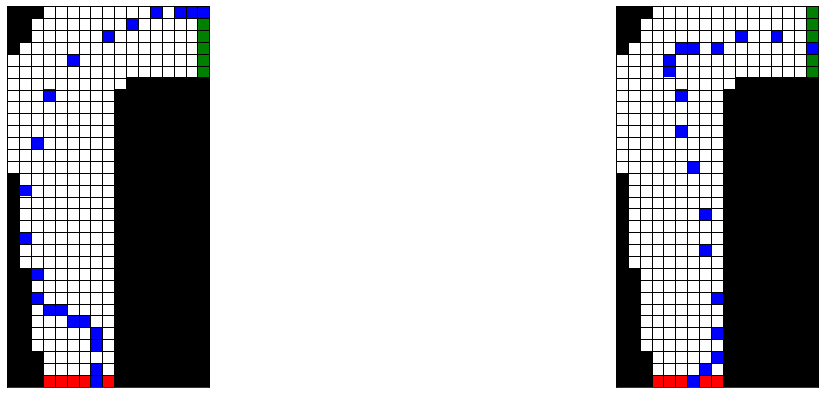

In [32]:
generate_opt_path(map_1,Q1_opt)

In [22]:
x = 31
y = 3
print(Q1_opt[x,y,5,5,:])

[  0.         -28.2570801  -99.94927057   0.           0.
   0.           0.           0.           0.        ]
